In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/unprocessed/WESAD"


In [3]:
def load_data_in_chunks(file_path, subject_id, chunksize=100000):
    """Load data in chunks, assign ID and return concatenated DataFrame."""
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk['ID'] = subject_id  # Assign subject ID to each chunk
        chunks.append(chunk)  # Collect the chunk
    return pd.concat(chunks, ignore_index=True)  # Concatenate all chunks


In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def save_batch(batch_df, output_file):
    """
    Saves a batch of the DataFrame to a single file in append mode.
    """
    batch_df.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)

def save_dataframe_in_batches(df, output_path, id_column='ID', batch_size=100):
    unique_ids = df[id_column].unique()
    total_ids = len(unique_ids)  # Total unique IDs
    total_batches = total_ids // batch_size + (total_ids % batch_size > 0)

    processed_ids = 0  # Counter for processed IDs
    print(f'Starting saving dataframe in batches. Total IDs: {total_ids}. Total batches: {total_batches}.')
    
    # Define the output file path
    output_file = f"{output_path}.csv"
    
    # Remove the existing output file if it exists (for fresh run)
    if os.path.exists(output_file):
        os.remove(output_file)
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = []
        for batch_number in range(total_batches):
            batch_ids = unique_ids[batch_number * batch_size:(batch_number + 1) * batch_size]
            
            # Filter the DataFrame for the current batch of IDs
            batch_df = df[df[id_column].isin(batch_ids)]

            # Submit the batch for saving using parallel processing
            futures.append(executor.submit(save_batch, batch_df, output_file))

            # Notify user of progress
            print(f"Processed batch {batch_number + 1}/{total_batches}.")
            for current_id in batch_ids:
                processed_ids += 1
                print(f'Processed ID: {current_id} ({processed_ids}/{total_ids})')

        # Ensure all tasks are completed before proceeding
        for future in as_completed(futures):
            future.result()  # This will raise an exception if any occurred in the threads

    print(f"Finished saving dataframe. Output saved to {output_file}")

In [5]:
def handle_missing_data(df, strategy='drop', fill_value=None):
    if strategy == 'drop':
        return df.dropna()
    elif strategy == 'fill':
        return df.fillna(fill_value)
    else:
        raise ValueError("Unsupported missing data strategy!")

In [6]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    r, p, t, l, d, e, obj = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return r, t, yn


In [7]:
def preprocess_data(dataset):
    # Calculate EDA levels
    unique_ids = dataset['ID'].unique()
    new_dataframe_eda = pd.DataFrame(columns=["cvx_phasic", "cvx_tonic"])
    
    for unique_id in unique_ids:
        subset_data = dataset[dataset['ID'] == unique_id]
        phasic, tonic, yn = calculate_eda_levels(subset_data['EDA'].values)
        temp_df = pd.DataFrame({"cvx_phasic": phasic, "cvx_tonic": tonic})
        new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)

    dataset = pd.concat([dataset, new_dataframe_eda], axis=1)
    return dataset

In [8]:
from collections import defaultdict

def create_wrist_sequences_df(merged_df, max_length=32):
    sequences = []
    
    # Initialize storage for the current sequence
    current_sequence = defaultdict(list)
    current_id = None
    
    for index, row in merged_df.iterrows():
        if current_id != row['ID']:
            # Store the previous sequence if it exists
            if current_id is not None:
                sequences.append({
                    'ID': current_id,
                    'EDA': current_sequence['EDA'],
                    'TEMP': current_sequence['TEMP'],
                    'labels': current_sequence['labels'],
                    'Time': current_sequence['Time'],
                    'X': current_sequence['X'],
                    'Y': current_sequence['Y'],
                    'Z': current_sequence['Z'],
                    'BVP': current_sequence['BVP']
                })
            
            # Reset for new ID
            current_id = row['ID']
            current_sequence = defaultdict(list)
            current_sequence['labels'] = row['labels']
        
        # Append values to the current sequence
        current_sequence['TEMP'].append(row['TEMP'])
        current_sequence['EDA'].append(row['EDA'])
        current_sequence['Time'].append(row['Time'])
        current_sequence['X'].append(row['X'])
        current_sequence['Y'].append(row['Y'])
        current_sequence['Z'].append(row['Z'])
        current_sequence['BVP'].append(row['BVP'])

        # Check if sequence length exceeds max_length
        if len(current_sequence['TEMP']) >= max_length:
            sequences.append({
                'ID': current_id,
                'EDA': current_sequence['EDA'],
                'TEMP': current_sequence['TEMP'],
                'labels': current_sequence['labels'],
                'Time': current_sequence['Time'],
                'X': current_sequence['X'],
                'Y': current_sequence['Y'],
                'Z': current_sequence['Z'],
                'BVP': current_sequence['BVP']
            })
            # Reset the current sequence for further accumulation
            current_sequence = defaultdict(list)
            current_sequence['labels'] = row['labels']

    # Append the last sequence if it's not empty
    if current_sequence['TEMP']:
        sequences.append({
            'ID': current_id,
            'EDA': current_sequence['EDA'],
            'TEMP': current_sequence['TEMP'],
            'labels': current_sequence['labels'],
            'Time': current_sequence['Time'],
            'X': current_sequence['X'],
            'Y': current_sequence['Y'],
            'Z': current_sequence['Z'],
            'BVP': current_sequence['BVP']
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

In [9]:
import pandas as pd
import numpy as np

def create_chest_sequences_df(merged_df, max_length=32):
    sequences = []
    total_ids = merged_df['ID'].nunique()  # Get the total number of unique IDs
    processed_ids = 0  # Initialize a counter for processed IDs

    # Group by ID
    grouped = merged_df.groupby('ID')

    for current_id, group in grouped:
        # Convert group to NumPy arrays for better performance
        temp = group['TEMP'].to_numpy()
        eda = group['EDA'].to_numpy()
        time = group['Time'].to_numpy()
        x = group['X'].to_numpy()
        y = group['Y'].to_numpy()
        z = group['Z'].to_numpy()
        ecg = group['ECG'].to_numpy()
        emg = group['EMG'].to_numpy()
        resp = group['RESP'].to_numpy()
        label = group['labels'].iloc[0]  # Assuming labels are consistent within the group

        # Initialize current sequence lengths and start index
        current_length = len(temp)
        start_idx = 0
        
        while start_idx < current_length:
            end_idx = min(start_idx + max_length, current_length)  # Define end index
            
            sequences.append({
                'ID': current_id,
                'EDA': eda[start_idx:end_idx].tolist(),
                'TEMP': temp[start_idx:end_idx].tolist(),
                'labels': label,
                'Time': time[start_idx:end_idx].tolist(),
                'X': x[start_idx:end_idx].tolist(),
                'Y': y[start_idx:end_idx].tolist(),
                'Z': z[start_idx:end_idx].tolist(),
                'ECG': ecg[start_idx:end_idx].tolist(),
                'EMG': emg[start_idx:end_idx].tolist(),
                'RESP': resp[start_idx:end_idx].tolist()
            })

            start_idx += max_length  # Move to the next batch
        
        # Update the processed IDs counter
        processed_ids += 1
        print(f'Processed ID: {current_id} ({processed_ids}/{total_ids})')  # Progress update

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    print('Finished creating chest sequences DataFrame.')  # Final notification
    return sequences_df


In [10]:
def encode_categorical(df, encoding_type='labels'):
    df_encoded = df.copy()
    df_encoded['labels'] = df['labels'].apply(lambda x: 1 if x == 2 else 0)

    if encoding_type == 'labels':
        le = preprocessing.LabelEncoder()
        le.fit(df_encoded['labels'])
        return df_encoded
    else:
        raise ValueError("Unsupported encoding type!")


In [11]:
def main(categorical_columns=None):
    print(f'Starting loading data')
    
    wrist_data_list = []
    chest_data_list = []
    
    for subject_id in range(2, 18):
        if subject_id == 12:
            continue  # Skip subject 12 as per your logic
        
        wrist_file_path = os.path.join(DATA_PATH, f'S{subject_id}', 'wrist', f'S{subject_id}.csv')
        # chest_file_path = os.path.join(DATA_PATH, f'S{subject_id}', 'chest', f'S{subject_id}.csv')
        
        # Load data in chunks and concatenate
        wrist_data = load_data_in_chunks(wrist_file_path, subject_id)
        # chest_data = load_data_in_chunks(chest_file_path, subject_id)

        # Append to the list
        wrist_data_list.append(wrist_data)
        # chest_data_list.append(chest_data)

    print(f'Finished loading data')

    # Concatenate all wrist and chest data into single DataFrames
    wrist_data_df = pd.concat(wrist_data_list, ignore_index=True)
    # chest_data_df = pd.concat(chest_data_list, ignore_index=True)

    print(f'Starting preprocessing')
    
    # Process the data
    wrist_sequences_df = create_wrist_sequences_df(wrist_data_df)
    print(f"wrist preprocessing")
    # chest_sequences_df = create_chest_sequences_df(chest_data_df)

    print(f'Finished creating sequences')

    # Encode categorical columns
    result_wrist_df = encode_categorical(wrist_sequences_df)
    # result_chest_df = encode_categorical(chest_sequences_df)
    print(f'Finished encoding')

    # Ensure the output directory exists
    output_dir = '../data'
    os.makedirs(output_dir, exist_ok=True)

    # Save DataFrames in batches
    # save_dataframe_in_batches(result_chest_df, output_path='../data/chest_result_df', id_column='ID', batch_size=100)
    save_dataframe_in_batches(result_wrist_df, output_path='../data/wrist_result_df', id_column='ID', batch_size=100)

    return result_wrist_df


In [12]:

x = main()
x

Starting loading data
Finished loading data
Starting preprocessing
wrist preprocessing
Finished creating sequences
Finished encoding
Starting saving dataframe in batches. Total IDs: 15. Total batches: 1.
Processed batch 1/1.
Processed ID: 2.0 (1/15)
Processed ID: 3.0 (2/15)
Processed ID: 4.0 (3/15)
Processed ID: 5.0 (4/15)
Processed ID: 6.0 (5/15)
Processed ID: 7.0 (6/15)
Processed ID: 8.0 (7/15)
Processed ID: 9.0 (8/15)
Processed ID: 10.0 (9/15)
Processed ID: 11.0 (10/15)
Processed ID: 13.0 (11/15)
Processed ID: 14.0 (12/15)
Processed ID: 15.0 (13/15)
Processed ID: 16.0 (14/15)
Processed ID: 17.0 (15/15)
Finished saving dataframe. Output saved to ../data/wrist_result_df.csv


,ID,EDA,TEMP,labels,Time,X,Y,Z,BVP
0,2.0,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[61.740338146354034, 52.30805561596093, 55.594...","[-21.3260103328524, 25.31312375983733, 9.55671...","[107.0287218220914, 4.72414838630618, 15.13969...","[-43.80470994467288, 40.68691715809934, 39.440..."
1,2.0,"[1.116375, 1.109969, 1.104843, 1.099718, 1.094...","[35.45, 35.45, 35.45, 35.45, 35.41, 35.41, 35....",0,"[8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 1...","[52.80665805521593, 53.56571492469504, 53.5398...","[19.818143125636457, 19.8479373538664, 20.1800...","[26.185778558872645, 25.969128357819997, 26.08...","[32.17611424727668, -35.34508777352216, -12.58..."
2,2.0,"[1.249634, 1.261166, 1.267572, 1.270135, 1.275...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0,"[16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, ...","[15.448993585182164, 12.938204272136954, 16.48...","[-57.52151294267716, -58.995929939268535, -58....","[16.514520932706443, 13.332073890226848, 12.41...","[-20.850967061052827, 9.883166727195226, 16.39..."
3,2.0,"[1.299606, 1.300887, 1.300887, 1.298324, 1.299...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0,"[24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, ...","[17.397301871565446, 16.716759145607966, 17.34...","[-58.17902678626336, -58.23808040701796, -58.1...","[13.8080130940609, 13.215059788462476, 13.4614...","[4.244412464691247, 10.979151173248974, -2.380..."
4,2.0,"[1.289355, 1.289355, 1.288074, 1.288074, 1.286...","[35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....",0,"[32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, ...","[16.63524038980479, 17.29696333955912, 17.0044...","[-58.24890750061535, -57.940442172862056, -57....","[13.33460738478547, 14.219805628801629, 13.771...","[-1.0013520084345755, 9.451374255720776, -2.29..."
...,...,...,...,...,...,...,...,...,...
10860,17.0,"[0.922787, 0.939419, 0.945816, 0.945816, 0.944...","[31.93, 31.91, 31.91, 31.91, 31.91, 31.93, 31....",0,"[5880.0, 5880.25, 5880.5, 5880.75, 5881.0, 588...","[-54.56991247338998, -39.78560816538871, -51.0...","[10.56392751411454, 7.738521547447364, 11.0593...","[23.82700888576157, 48.86505802156928, 36.8109...","[-20.03321028438718, -88.98954700141856, -14.0..."
10861,17.0,"[0.931742, 0.929184, 0.933022, 0.929184, 0.931...","[31.95, 31.99, 31.99, 31.99, 31.99, 31.99, 31....",0,"[5888.0, 5888.25, 5888.5, 5888.75, 5889.0, 588...","[-49.81202547106978, -49.57909033777656, -49.5...","[11.160610398456942, 11.168164603616306, 11.15...","[38.32620857209238, 38.42255694101257, 38.5660...","[9.042382042065706, -17.381097045892904, 12.14..."
10862,17.0,"[0.922787, 0.908713, 0.917669, 0.904875, 0.906...","[32.0, 32.0, 32.0, 32.0, 32.0, 32.05, 32.05, 3...",0,"[5896.0, 5896.25, 5896.5, 5896.75, 5897.0, 589...","[-30.145914598014997, -29.97744602199557, -31....","[40.987573799609656, 38.78557330050637, 38.365...","[39.38525508918834, 40.32989087005436, 39.8961...","[-108.02500112605662, -205.4745274731615, 43.7..."
10863,17.0,"[0.803802, 0.805081, 0.806361, 0.820434, 0.849...","[32.03, 32.03, 32.03, 32.03, 32.03, 31.99, 31....",0,"[5904.0, 5904.25, 5904.5, 5904.75, 5905.0, 590...","[-49.8721905613604, -62.82294750206409, -49.28...","[42.61950595865988, 68.78482603847239, 48.5223...","[-17.74219078514143, -21.49583461842878, -9.53...","[2.2384887820753288, 6.704893491735473, -0.071..."


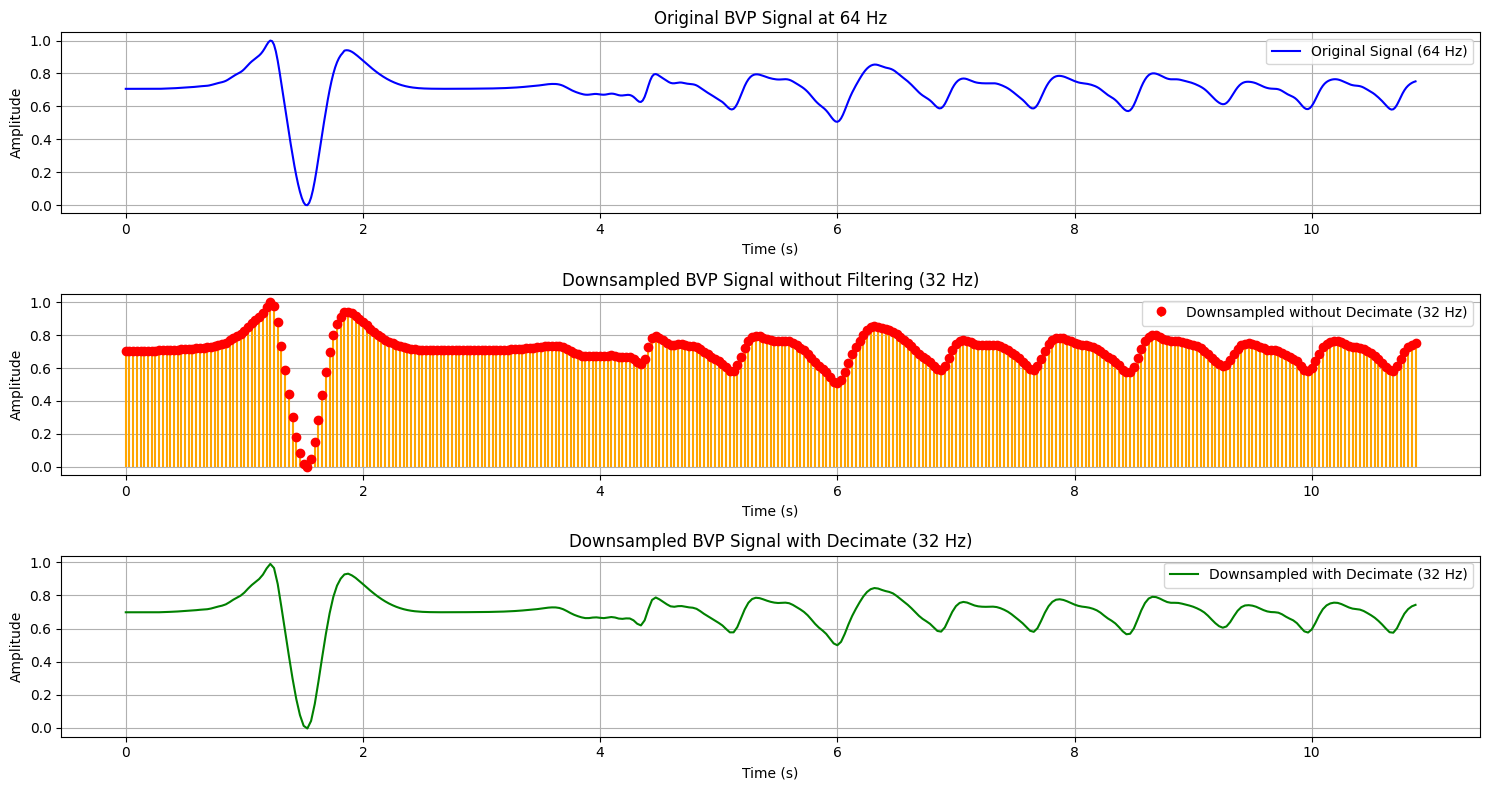

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate

# BVP signal data (64 Hz sampling rate)
bvp_data = np.array([
    -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00,
    0.00, 0.01, 0.01, -0.00, -0.03, -0.05, -0.05, 0.00, 0.13, 0.36,
    0.66, 1.01, 1.37, 1.72, 2.06, 2.40, 2.79, 3.24, 3.80, 4.42,
    5.06, 5.66, 6.20, 6.68, 7.15, 7.68, 8.31, 9.14, 10.09, 11.04,
    11.88, 12.56, 13.14, 13.76, 14.65, 15.96, 17.91, 20.32, 22.90, 25.38,
    27.58, 29.57, 31.68, 34.32, 37.81, 42.54, 48.15, 54.10, 59.83, 64.97,
    69.58, 74.14, 79.34, 85.71, 93.76, 103.00, 112.62, 121.73, 129.77, 136.75,
    143.30, 150.75, 157.77, 166.64, 177.95, 191.79, 206.97, 220.57, 228.25, 225.36,
    208.53, 176.87, 132.76, 80.05, 23.07, -34.94, -92.44, -149.16, -205.23,
    -260.37, -313.74, -363.87, -409.83, -450.91, -486.50, -515.74, -537.23,
    -549.22, -549.96, -538.37, -514.21, -478.67, -433.88, -382.45, -327.02,
    -269.84, -212.63, -156.66, -102.95, -52.37, -5.90, 35.58, 71.43,
    101.35, 125.50, 144.38, 158.69, 169.15, 180.75, 182.57, 182.07,
    179.51, 175.23, 169.65, 163.18, 156.15, 148.81, 141.30, 133.69,
    126.02, 118.33, 110.69, 103.16, 95.80, 88.68, 81.83, 75.25,
    68.95, 62.95, 57.25, 51.86, 46.78, 42.03, 37.59, 33.45,
    29.61, 26.07, 22.81, 19.83, 17.11, 14.67, 12.48, 10.54,
    8.83, 7.35, 6.07, 4.97, 4.05, 3.27, 2.62, 2.09,
    1.65, 1.30, 1.01, 0.79, 0.61, 0.48, 0.37, 0.29,
    0.24, 0.20, 0.18, 0.17, 0.17, 0.18, 0.20, 0.22,
    0.26, 0.29, 0.33, 0.37, 0.42, 0.46, 0.51, 0.56,
    0.61, 0.66, 0.72, 0.78, 0.84, 0.92, 1.00, 1.08,
    1.18, 1.29, 1.42, 1.55, 1.71, 1.88, 2.07, 2.28,
    2.51, 2.77, 3.06, 3.37, 3.72, 4.10, 4.51, 4.96,
    5.44, 5.96, 6.52, 7.12, 7.79, 8.51, 9.27, 10.06,
    10.84, 11.61, 12.37, 13.15, 14.01, 14.97, 16.07, 17.28,
    18.56, 19.81, 20.97, 21.95, 22.69, 23.14, 23.24, 22.89,
    21.95, 20.31, 17.85, 14.56, 10.47, 5.85, 0.99, -3.76,
    -8.15, -12.06, -15.53, -18.65, -21.51, -24.09, -26.20, -27.58,
    -28.01, -27.48, -26.30, -25.00, -24.15, -24.16, -25.02, -26.36,
    -27.48, -27.77, -26.97, -25.34, -23.61, -22.65, -23.06, -24.88,
    -27.48, -29.91, -31.33, -31.36, -30.31, -28.99, -28.34, -29.23,
    -32.31, -37.87, -45.61, -54.13, -60.77, -62.03, -54.86, -38.11,
    -13.59, 14.22, 39.73, 58.35, 68.10, 69.90, 66.53, 60.93,
    54.97, 49.20, 43.45, 37.66, 32.30, 28.27, 26.25, 26.26,
    27.59, 29.18, 29.99, 29.54, 28.06, 26.12, 24.38, 23.19,
    22.42, 21.48, 19.61, 16.28, 11.39, 5.38, -1.05, -7.26,
    -12.96, -18.27, -23.50, -28.90, -34.47, -39.98, -45.24, -50.41,
    -55.95, -62.50, -70.37, -79.28, -88.05, -94.85, -97.61, -94.67,
    -85.37, -70.18, -50.62, -28.78, -6.82, 13.49, 30.94, 44.95,
    55.42, 62.54, 66.73, 68.49, 68.35, 66.83, 64.36, 61.35,
    58.13, 55.00, 52.17, 49.72, 47.66, 45.99, 44.77, 44.12,
    44.12, 44.65, 45.36, 45.64, 44.93, 42.85, 39.41, 34.90,
    29.77, 24.44, 19.08, 13.64, 7.87, 1.43, -5.95, -14.47,
    -24.06, -34.43, -45.02, -55.19, -64.43, -72.50, -79.63, -86.45,
    -93.81, -102.50, -112.90, -124.67, -136.71, -147.25, -154.25, -155.92,
    -151.12, -139.77, -122.82, -102.02, -79.50, -57.16, -36.27, -17.28,
    0.01, 16.18, 31.72, 46.81, 61.23, 74.50, 86.15, 95.88,
    103.61, 109.35, 113.08, 114.78, 114.49, 112.53, 109.47, 106.08,
    103.03, 100.60, 98.64, 96.58, 93.77, 89.70, 84.23, 77.65,
    70.48, 63.23, 56.21, 49.42, 42.59, 35.39, 27.55, 19.05,
    10.05, 0.86, -8.16, -16.66, -24.36, -31.13, -37.04, -42.46,
    -48.06, -54.54, -62.36, -71.35, -80.52, -88.17, -92.32, -91.30,
    -84.30, -71.65, -54.72, -35.54, -16.19, 1.63, 16.83, 28.96,
    37.96, 44.07, 47.57, 48.79, 48.10, 45.90, 42.69, 39.02,
    35.43, 32.34, 29.97, 28.32, 27.24, 26.54, 26.11, 25.94,
    26.04, 26.35, 26.67, 26.69, 26.06, 24.59, 22.27, 19.25,
    15.72, 11.79, 7.45, 2.53, -3.10, -9.43, -16.29, -23.38,
    -30.44, -37.40, -44.45, -52.01, -60.42, -69.68, -79.07, -87.18,
    -92.15, -92.29, -86.56, -75.05, -58.92, -40.05, -20.46, -1.82,
    14.82, 28.90, 40.29, 49.05, 55.29, 59.21, 61.14, 61.40,
    60.35, 58.28, 55.42, 51.97, 48.14, 44.17, 40.25, 36.58,
    33.32, 30.60, 28.50, 26.95, 25.79, 24.72, 23.39, 21.60,
    19.28, 16.45, 13.11, 9.07, 4.09, -1.95, -8.89, -16.19,
    -23.18, -29.40, -34.88, -40.10, -45.85, -52.73, -60.96, -70.35,
    -80.29, -89.94, -98.22, -103.81, -105.28, -101.45, -91.75, -76.53,
    -57.05, -35.14, -12.73, 8.53, 27.48, 43.37, 55.85, 64.81,
    70.41, 73.03, 73.24, 71.64, 68.75, 65.00, 60.71, 56.26,
    52.07, 48.63, 46.30, 45.17, 44.96, 45.13, 45.09, 44.39,
    42.92, 40.87, 38.57, 36.28, 34.08, 31.81, 29.25, 26.26,
    22.81, 18.97, 14.83, 10.31, 5.18, -0.85, -7.99, -16.19,
    -25.15, -34.36, -43.33, -51.72, -59.27, -65.69, -70.43, -72.72,
    -71.70, -66.84, -58.13, -46.32, -32.61, -18.40, -4.91, 6.97,
    16.71, 24.10, 29.13, 32.09, 33.37, 33.43, 32.65, 31.18,
    29.02, 26.07, 22.43, 18.33, 14.14, 10.20, 6.80, 4.11,
    2.20, 1.07, 0.55, 0.27, -0.41, -2.12, -5.27, -9.83,
    -15.27, -20.81, -25.81, -30.08, -33.98, -38.32, -43.99, -51.53,
    -60.90, -71.38, -81.65, -90.14, -95.25, -95.76, -91.06, -81.26,
    -67.18, -50.23, -32.10, -14.44, 1.39, 14.57, 24.84, 32.43,
    37.83, 41.59, 44.05, 45.36, 45.46, 44.33, 42.04, 38.85,
    35.03, 30.95, 26.88, 23.09, 19.86, 17.43, 15.88, 14.97,
    14.11, 12.59, 9.93, 6.04, 1.28, -3.82, -8.95, -14.15,
    -19.75, -26.06, -33.18, -40.95, -49.23, -57.97, -67.28, -77.02,
    -86.46, -94.12, -98.06, -96.54, -88.80, -75.44, -58.24, -39.67,
    -21.99, -6.74, 5.51, 15.00, 22.32, 28.01, 32.33, 35.34
])

bvp_data_normalized = (bvp_data - np.min(bvp_data)) / (np.max(bvp_data) - np.min(bvp_data))

# Create a time vector for the original signal
fs_original = 64  # original sampling frequency
t = np.linspace(0, len(bvp_data_normalized) / fs_original, len(bvp_data_normalized), endpoint=False)

# Downsample without filtering (simple slicing)
downsampling_factor = 2
t_no_filter = t[::downsampling_factor]
bvp_no_filter = bvp_data_normalized[::downsampling_factor]

# Downsample using the decimate function (with filtering)
bvp_decimated = decimate(bvp_data_normalized, downsampling_factor)

# New time vector for the decimated signal
t_decimated = np.linspace(0, len(bvp_decimated) / (fs_original / downsampling_factor), len(bvp_decimated), endpoint=False)

# Plotting
plt.figure(figsize=(15, 8))

# Original Signal
plt.subplot(3, 1, 1)
plt.plot(t, bvp_data_normalized, label='Original Signal (64 Hz)', color='blue')
plt.title('Original BVP Signal at 64 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Downsampled without Decimate (simple slicing)
plt.subplot(3, 1, 2)
plt.stem(t_no_filter, bvp_no_filter, label='Downsampled without Decimate (32 Hz)', linefmt='orange', markerfmt='ro', basefmt=" ")
plt.title('Downsampled BVP Signal without Filtering (32 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Downsampled with Decimate
plt.subplot(3, 1, 3)
plt.plot(t_decimated, bvp_decimated, label='Downsampled with Decimate (32 Hz)', color='green')
plt.title('Downsampled BVP Signal with Decimate (32 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
